In [2]:
import numpy as np
import pandas as pd
import os, sys, glob, shutil 
from config import *
from plotting_functions import *
import analysis_helpers as helper
sys.path.insert(0,'../..')
%load_ext autoreload
%autoreload 2
%matplotlib inline
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import inspect
from scipy.spatial.distance import pdist, cdist,squareform
from scipy.stats import zscore, wasserstein_distance, ttest_1samp, ttest_rel, ttest_ind, sem,f_oneway, spearmanr, pearsonr
from sklearn.decomposition import PCA
import matplotlib as mpl
import scprep
import nibabel as nib
from nilearn.maskers import NiftiMasker
from nibabel import Nifti1Image
from nilearn import plotting,image  
import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 42 
matplotlib.rcParams["pdf.use14corefonts"] = True
sns.set_context(context_params)

/gpfs/milgram/project/casey/elb77/conda_envs/rtcloud_av1/lib/python3.7/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


# joystick results

mse Ttest_relResult(statistic=8.825518084406122, pvalue=3.783117565881314e-08)
0.00019998000199980003
mantel_z Ttest_relResult(statistic=-3.8851362620022587, pvalue=0.0009960558440190812)
0.0007999200079992001


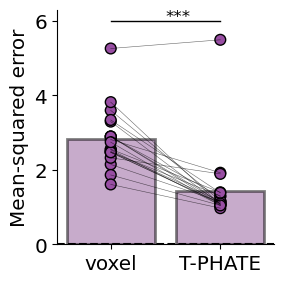

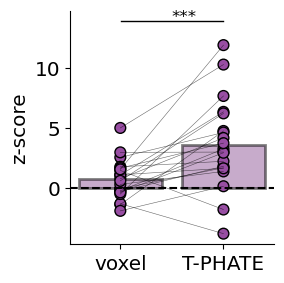

In [10]:
joy_df = pd.read_csv('./results/final_results/joystick_results.csv',index_col=0)
joy_df = joy_df[['embedding','mantel_z','mantel_rho','mse','subject_id']]

ynames = ['mse', 'mantel_z']
titles = [ '', '']
ylabels = [ 'Mean-squared error', 'z-score']
pal = [sns.color_palette('Set1',6)[3] for i in [1,-1]]
#pal = ['w']*2
yplus = [0.5,2]
for i in range(2):
    fig,ax=plt.subplots(1,1, figsize=(3,3))
    g=sns.barplot(x='embedding', y=ynames[i], data=joy_df, palette=pal,ax=ax, alpha=0.5, edgecolor='k',linewidth=2,errorbar=None)
    ax.axhline(0, ls='--', c='k') 
    points0,points1=[],[]
    #g=sns.stripplot(x='embedding', y=ynames[i], data=res, palette='inferno', ax=ax, alpha=1, linewidth=1)
    for sub in joy_df.subject_id.unique():
        p0 = joy_df[(joy_df['subject_id']==sub)&(joy_df['embedding']==0)][ynames[i]].item()
        p1 = joy_df[(joy_df['subject_id']==sub)&(joy_df['embedding']==1)][ynames[i]].item()
        points0.append(p0)
        points1.append(p1)
        ax.scatter([0,1],[p0,p1],linewidth=1,s=60,edgecolors='k', c=[pal[0], pal[1]])
        ax.plot([0,1],[p0,p1],color='k',alpha=0.6, linewidth=0.4)
        
    g.set(title=titles[i], xticklabels=['voxel','T-PHATE'], ylabel=ylabels[i], xlabel='')
    ttest_results =ttest_rel(points0,points1) 
    p=ttest_results[1]
    print(ynames[i], ttest_results)
    
    _,pv,_=helper.permutation_test(np.array([points0,points1]),n_iterations=10000, alternative='two-sided')
    print(pv)
    if pv > 0.5: pv=1-pv
    pstr = determine_symbol(pv)
    yloc = np.max(np.concatenate((points0,points1)))+yplus[i]
    
    if pstr!=None:
        ax.axhline(xmin=0+0.25, xmax=1-0.25, y=yloc, color='k', lw=1)
        ax.text(x=0.5, y=yloc+0.0004, s=pstr)
    sns.despine()
    plt.tight_layout()
    plt.savefig(f'plots/joystick_{ynames[i]}.pdf', transparent=True, bbox_inches='tight')
    

# neural variance explained 

In [32]:
df_runchange=pd.read_csv('./results/final_results/runwise_component_EVR_neural_analysis_run_change.csv')
cong_df = df_runchange[df_runchange['congruent']==True].reset_index(drop=True)
make_barplot_points(cong_df, 
                    'delta_run_perturb', 
                    'session_type', 
                    exclude_subs=exclude_from_neural_analyses, ylim=[-0.045, .08],
                    outfn='plots/neural_EVR_within_session.pdf',
                    plus_bot=0.01, plus_top=0.02, n_iter=10000, sample_alternative='greater',
                    pairwise_alternative='greater', title='')

['avatarRT_sub_05', 'avatarRT_sub_06', 'avatarRT_sub_07', 'avatarRT_sub_08', 'avatarRT_sub_10', 'avatarRT_sub_11', 'avatarRT_sub_13', 'avatarRT_sub_14', 'avatarRT_sub_15', 'avatarRT_sub_16', 'avatarRT_sub_17', 'avatarRT_sub_18', 'avatarRT_sub_19', 'avatarRT_sub_21', 'avatarRT_sub_22', 'avatarRT_sub_23', 'avatarRT_sub_24', 'avatarRT_sub_25']
IM 0.0044, WM 0.045, OM 0.8242
greater
IMvWM: 0.262, IMvOM: 0.0052, WMvOM: 0.0347


# Supplement - comparing delta EVR within session, across components

In [38]:
h1s = {'IM':['greater','greater','two-sided'], 'WMP':['less', 'two-sided', 'greater'], 'OMP': ['two-sided', 'two-sided', 'two-sided']}
for M in ORDER:
    ses_df = df_runchange[(df_runchange['session_type']==M)]
    make_barplot_points(ses_df, 
                        'delta_run_perturb', 
                        'comparison_component_name', 
                        exclude_subs=exclude_from_neural_analyses, ylim=[-0.1, .1],
                        outfn=f'plots/neural_EVR_comparison_{M}_session.pdf',
                        title=f'',plus_bot=0.01, plus_top=0.02, n_iter=10000, sample_alternative='greater',
                        pairwise_alternative= h1s[M])

['avatarRT_sub_05', 'avatarRT_sub_06', 'avatarRT_sub_07', 'avatarRT_sub_08', 'avatarRT_sub_10', 'avatarRT_sub_11', 'avatarRT_sub_13', 'avatarRT_sub_14', 'avatarRT_sub_15', 'avatarRT_sub_16', 'avatarRT_sub_17', 'avatarRT_sub_18', 'avatarRT_sub_19', 'avatarRT_sub_21', 'avatarRT_sub_22', 'avatarRT_sub_23', 'avatarRT_sub_24', 'avatarRT_sub_25']
IM 0.0044, WM 0.2615, OM 0.4817
IMvWM: 0.0551, IMvOM: 0.1279, WMvOM: 0.7723
['avatarRT_sub_05', 'avatarRT_sub_06', 'avatarRT_sub_07', 'avatarRT_sub_08', 'avatarRT_sub_10', 'avatarRT_sub_11', 'avatarRT_sub_13', 'avatarRT_sub_14', 'avatarRT_sub_15', 'avatarRT_sub_16', 'avatarRT_sub_17', 'avatarRT_sub_18', 'avatarRT_sub_19', 'avatarRT_sub_21', 'avatarRT_sub_22', 'avatarRT_sub_23', 'avatarRT_sub_24', 'avatarRT_sub_25']
IM 0.8041, WM 0.045, OM 0.9389
IMvWM: 0.0114, IMvOM: 0.3314, WMvOM: 0.01
['avatarRT_sub_05', 'avatarRT_sub_06', 'avatarRT_sub_07', 'avatarRT_sub_08', 'avatarRT_sub_10', 'avatarRT_sub_11', 'avatarRT_sub_13', 'avatarRT_sub_14', 'avatarRT_su